# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data loading

In [4]:
data_folder = 'data/'
Go_ed = pd.read_csv(data_folder + 'Gowalla_edges.csv', sep="\t", names = ["id1","id2"])
Go_ch = pd.read_csv(data_folder + "Gowalla_totalCheckins.csv", sep="\t", names = ["user","time","latitude","longitude","location_id"])
Br_ed = pd.read_csv(data_folder + 'Brightkite_edges.csv', sep="\t", names = ["id1","id2"])
Br_ch = pd.read_csv(data_folder + "Brightkite_totalCheckins.csv", sep="\t", names = ["user","time","latitude","longitude","location_id"])

Let's see if it makes sense

In [5]:
Go_ed

,id1,id2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
1900649,196586,196539
1900650,196587,196540
1900651,196588,196540
1900652,196589,196547


It seems that it's ok!!

# Data preparation

## Inference of the home of the users

### World partition

Considering 0.1 grades = 11.1km, the partition of the world into 25x25 km cells is:

In [6]:
side=25*0.1/11.1
Go_ch["cell"]=(Go_ch["latitude"]+90)//side + (Go_ch["longitude"]+180)//side*int(180/side)
Br_ch["cell"]=(Br_ch["latitude"]+90)//side + (Br_ch["longitude"]+180)//side*int(180/side)

### Data cleaning

In [7]:
Br_ch.sort_values(by = "latitude", ascending = False).head(15)

,user,time,latitude,longitude,location_id,cell
3231786,14201,2009-01-18T02:29:34Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231781,14201,2009-01-19T07:34:58Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231782,14201,2009-01-18T23:56:08Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231783,14201,2009-01-18T12:24:39Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231784,14201,2009-01-18T10:32:33Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231785,14201,2009-01-18T04:05:27Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231787,14201,2009-01-16T13:45:22Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231788,14201,2009-01-16T13:45:20Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231789,14201,2009-01-15T23:04:57Z,151.092167,-33.870000,8d522300e25911dda5f6003048c10834,518822.0
3231793,14201,2009-01-14T17:36:55Z,151.092167,-33.870000,8d522300e25911dda5f6003048c10834,518822.0


Oh noo!!! It seems to be values of latitude (and longitude) that do not make sense. Range(latitude) = [-90,90] & Range(longitude) = [-180,180].
Let's drop them:

In [8]:
Go_ch = Go_ch.drop(Go_ch[Go_ch.latitude<-90].index)
Go_ch = Go_ch.drop(Go_ch[Go_ch.latitude>90].index)
Go_ch = Go_ch.drop(Go_ch[Go_ch.longitude<-180].index)
Go_ch = Go_ch.drop(Go_ch[Go_ch.longitude>180].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.latitude<-90].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.latitude>90].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.longitude<-180].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.longitude>180].index)

### Mean latitude and longitude of the most common cell of each user

In [9]:
#FIRST, THE NUMBER OF TIMES A CHECK-IN HAPPENS IN A CELL FOR EACH USER IS COUNTED
Go_ch_cell_count = Go_ch.groupby(["user","cell"]).count().reset_index()[["user","cell","time"]].rename(columns = {"time":"cell_count"})
#THEN, FOR EACH USER THE NUMBER OF CHECK-INS OF THE MOST COMMON CELL IS OBTAINED
Go_ch_cell_max = Go_ch_cell_count.groupby("user")["cell_count"].max().reset_index().rename(columns={"cell_count":"cell_max"})
#FINALLY, FOR EVERY USER IN EACH CELL, THE MEAN OF THE LONGITUDE AND LATITUDE IS CALCULATED
Go_ch_cell_mean = Go_ch.groupby(["user","cell"])["latitude","longitude"].agg("mean").reset_index().rename(columns = {"latitude":"latitude_mean","longitude":"longitude_mean"})

## SAME   FOR   OTHER   DATASET
Br_ch_cell_count = Br_ch.groupby(["user","cell"]).count().reset_index()[["user","cell","time"]].rename(columns = {"time":"cell_count"})
Br_ch_cell_max = Br_ch_cell_count.groupby("user")["cell_count"].max().reset_index().rename(columns={"cell_count":"cell_max"})
Br_ch_cell_mean = Br_ch.groupby(["user","cell"])["latitude","longitude"].agg("mean").reset_index().rename(columns = {"latitude":"latitude_mean","longitude":"longitude_mean"})

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [10]:
print(Go_ch_cell_count)
print(Go_ch_cell_max)
print(Go_ch_cell_mean)

          user      cell  cell_count
0            0  204311.0           3
1            0  204312.0          20
2            0  205109.0           2
3            0  205110.0           1
4            0  259449.0           6
...        ...       ...         ...
674591  196578  636633.0          15
674592  196578  637432.0           9
674593  196578  638231.0           1
674594  196585  669385.0           1
674595  196585  670183.0           1

[674596 rows x 3 columns]
          user  cell_max
0            0       119
1            1         1
2            2       750
3            4       204
4            5        30
...        ...       ...
107087  196544         1
107088  196561       124
107089  196577         3
107090  196578        15
107091  196585         1

[107092 rows x 2 columns]
          user      cell  latitude_mean  longitude_mean
0            0  204311.0      37.616356     -122.386150
1            0  204312.0      37.780813     -122.406536
2            0  205109.0      37.4

In [11]:
#THE MEAN VALUES OF THE CHECK-INS FOR EACH CELL&USER IS MERGED WITH THE NUMBER OF CHECK-INS OF EACH CELL AND WITH THE MAXIMUM OF CHECK-INS PER CELL&USER
Go_home = Go_ch_cell_mean.merge(Go_ch_cell_count).merge(Go_ch_cell_max)
##THE CELLS IN WHICH THE NUMBER OF CHECK-INS MATCH THE NUMBER OF CHEK-INS OF THE MOST COMMON CELL FOR EACH USER STAY. THE OTHER ARE NOT USED
Go_home = Go_home[(Go_home["cell_max"] == Go_home["cell_count"])][["user","latitude_mean","longitude_mean"]]
##FOR THAT USERS THAT HAVE MULTIPLE CELLS WITH THE SAME NUMBER OF CHECK-INS (BEING THE MOST COMMON) THE VALUES ARE MEANED
Go_home = Go_home.groupby("user").mean()

## SAME   FOR   OTHER   DATASET
Br_home = Br_ch_cell_mean.merge(Br_ch_cell_count).merge(Br_ch_cell_max)
Br_home = Br_home[(Br_home["cell_max"] == Br_home["cell_count"])][["user","latitude_mean","longitude_mean"]]
Br_home = Br_home.groupby("user").mean()

In [12]:
Go_home

,latitude_mean,longitude_mean
user,,
0,30.258624,-97.748824
1,47.204338,4.499703
2,37.839812,-122.252373
4,37.778756,-122.437161
5,30.294812,-97.730042
...,...,...
196544,-25.433409,-49.281533
196561,37.529416,-122.005527
196577,51.529196,0.062099


Notice that in this DataFrame the index is the user.

## Let's calculate the distances between each edge

### Problem: some users do not have home

In [13]:
##THE USER WHICH HAVE AT LEAST ONCE CHECKED-IN ARE STORED FOR BOTH DATASETS
Go_users = Go_ch_cell_count["user"].drop_duplicates()
Br_users = Br_ch_cell_count["user"].drop_duplicates()
##THE EDGES WHOSE USERS HAVE NEVER CHECKED-IN ARE DROPPED FOR BOTH DATASETS
Go_ed = Go_ed[Go_ed["id1"].isin(Go_users)]
Go_ed = Go_ed[Go_ed["id2"].isin(Go_users)]
Br_ed = Br_ed[Br_ed["id1"].isin(Br_users)]
Br_ed = Br_ed[Br_ed["id2"].isin(Br_users)]

In [14]:
Go_ed

,id1,id2
0,0,1
1,0,2
3,0,4
4,0,5
6,0,7
...,...,...
1900533,196508,196109
1900540,196512,196160
1900541,196513,196160
1900549,196520,4727


In [15]:
#FIRST THE LATITUDE AND LONGITUDE OF THE FIRST USER IS OBTAINED SETTING THIS USER AS THE INDEX AND USING THE "Go_home" DATA FRAME
Go_ed = Go_ed.set_index("id1")
Go_ed["id1_lat"] = Go_home["latitude_mean"]
Go_ed["id1_lon"] = Go_home["longitude_mean"]
#THEN THE PROCESS IS REPEATED FOR THE SECOND USER
Go_ed = Go_ed.reset_index().set_index("id2")
Go_ed["id2_lat"] = Go_home["latitude_mean"]
Go_ed["id2_lon"] = Go_home["longitude_mean"]
#FINALLY THE INDEX IS RESETED SO THAT ALL INFORMATION IS EQUALLY ACCESIBLE
Go_ed = Go_ed.reset_index()

#SAME FOR BRIGHTKITE DATASET
Br_ed = Br_ed.set_index("id1")
Br_ed["id1_lat"] = Br_home["latitude_mean"]
Br_ed["id1_lon"] = Br_home["longitude_mean"]
Br_ed = Br_ed.reset_index().set_index("id2")
Br_ed["id2_lat"] = Br_home["latitude_mean"]
Br_ed["id2_lon"] = Br_home["longitude_mean"]
Br_ed = Br_ed.reset_index()

In [16]:
Go_ed

,id2,id1,id1_lat,id1_lon,id2_lat,id2_lon
0,1,0,30.258624,-97.748824,47.204338,4.499703
1,2,0,30.258624,-97.748824,37.839812,-122.252373
2,4,0,30.258624,-97.748824,37.778756,-122.437161
3,5,0,30.258624,-97.748824,30.294812,-97.730042
4,7,0,30.258624,-97.748824,30.264583,-97.744253
...,...,...,...,...,...,...
913655,196109,196508,51.769524,-0.572672,37.316198,-121.988518
913656,196160,196512,30.192386,-81.565471,30.237752,-81.538301
913657,196160,196513,30.136064,-81.534063,30.237752,-81.538301
913658,4727,196520,52.353922,4.880389,52.358856,4.897302


Source: https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance

In [17]:
#FIRST THE DISTANCE BETWEEN THE LATITUDES FOR EACH EDGE IS OBTAINED
Go_ed["lat_dis"] = abs(Go_ed["id1_lat"]-Go_ed["id2_lat"])*110.574
#THEN THE DISTANCE BETWEEN THE LONGITUDES FOR EACH EDGE IS OBTAINED
Go_ed["lon_dis"] = abs((Go_ed["id1_lon"]-Go_ed["id2_lon"])*np.cos((Go_ed["id1_lat"]+Go_ed["id2_lat"])/2))*111.320
#FINALLY THE TOTAL DISTANCE IS CALCULATED
Go_ed["distance"] = np.sqrt(Go_ed["lat_dis"]**2+Go_ed["lon_dis"]**2)

#SAME FOR BRIGHTKITE DATASET
Br_ed["lat_dis"] = abs(Br_ed["id1_lat"]-Br_ed["id2_lat"])*110.574
Br_ed["lon_dis"] = abs((Br_ed["id1_lon"]-Br_ed["id2_lon"])*np.cos((Br_ed["id1_lat"]+Br_ed["id2_lat"])/2))*111.320
Br_ed["distance"] = np.sqrt(Br_ed["lat_dis"]**2+Br_ed["lon_dis"]**2)

In [18]:
Go_ed

,id2,id1,id1_lat,id1_lon,id2_lat,id2_lon,lat_dis,lon_dis,distance
0,1,0,30.258624,-97.748824,47.204338,4.499703,1873.755441,5836.691463,6130.083742
1,2,0,30.258624,-97.748824,37.839812,-122.252373,838.282281,2382.874110,2526.025773
2,4,0,30.258624,-97.748824,37.778756,-122.437161,831.531128,2358.898261,2501.168732
3,5,0,30.258624,-97.748824,30.294812,-97.730042,4.001488,0.874595,4.095952
4,7,0,30.258624,-97.748824,30.264583,-97.744253,0.658963,0.205827,0.690360
...,...,...,...,...,...,...,...,...,...
913655,196109,196508,51.769524,-0.572672,37.316198,-121.988518,1598.162046,11447.462208,11558.482293
913656,196160,196512,30.192386,-81.565471,30.237752,-81.538301,5.016327,1.093547,5.134139
913657,196160,196513,30.136064,-81.534063,30.237752,-81.538301,11.244090,0.158128,11.245201
913658,4727,196520,52.353922,4.880389,52.358856,4.897302,0.545652,0.935684,1.083162


In [19]:
#THE ONLY CRUCIAL INFO IS THE DISTANCE
Go_ed = Go_ed[["id1","id2","distance"]]
Br_ed = Br_ed[["id1","id2","distance"]]

In [20]:
print(Go_ed,Br_ed)

           id1     id2      distance
0            0       1   6130.083742
1            0       2   2526.025773
2            0       4   2501.168732
3            0       5      4.095952
4            0       7      0.690360
...        ...     ...           ...
913655  196508  196109  11558.482293
913656  196512  196160      5.134139
913657  196513  196160     11.245201
913658  196520    4727      1.083162
913659  196531  196283      2.628391

[913660 rows x 3 columns]           id1    id2      distance
0           0      1   1105.590585
1           0      2      0.694956
2           0      3    971.582185
3           0      4  13992.477979
4           0      5    974.250410
...       ...    ...           ...
394329  58225  58226      0.000000
394330  58225  58227      0.000000
394331  58226  58220     21.653290
394332  58226  58225      0.000000
394333  58227  58225      0.000000

[394334 rows x 3 columns]


## Probability

In [21]:
print(Go_ed["distance"].max(),Br_ed["distance"].max())

35020.378315371185 35831.401590055175


As we can see in the above cell the maximum distance between users in both Datasets is approximately 35000km

In [22]:
#SPLITTIG THE DIFFERENT DISTANCES INTO BINS LOGARITHMICALLY SPACED
bins = np.logspace(-1,np.log10(35000),70)
#CREATION OF A HELPING DATAFRAME WITH THE ABSOLUTE ERROR BETWEEN THE DISTANCES AND THE OPTIONS IN BINS
Go_help = pd.DataFrame()
Br_help = pd.DataFrame()
for i in range(len(bins)):
    Go_help[i] = (abs(Go_ed["distance"]-bins[i]))
    Br_help[i] = (abs(Br_ed["distance"]-bins[i]))

In [23]:
Go_help

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,6129.983742,6129.963419,6129.938966,6129.909543,6129.874140,6129.831542,6129.780288,6129.718617,6129.644412,6129.555127,...,490.994717,1836.599438,3455.672007,5403.789414,7747.823588,10568.236872,13961.844002,18045.135419,22958.275968,28869.916258
1,2525.925773,2525.905450,2525.880997,2525.851574,2525.816171,2525.773574,2525.722319,2525.660648,2525.586444,2525.497159,...,4095.052685,5440.657407,7059.729975,9007.847382,11351.881557,14172.294840,17565.901970,21649.193387,26562.333937,32473.974227
2,2501.068732,2501.048409,2501.023955,2500.994532,2500.959130,2500.916532,2500.865278,2500.803607,2500.729402,2500.640117,...,4119.909727,5465.514449,7084.587017,9032.704424,11376.738599,14197.151882,17590.759012,21674.050429,26587.190979,32498.831268
3,3.995952,3.975629,3.951175,3.921752,3.886350,3.843752,3.792498,3.730827,3.656622,3.567337,...,6616.982507,7962.587229,9581.659797,11529.777204,13873.811379,16694.224662,20087.831792,24171.123209,29084.263758,34995.904048
4,0.590360,0.570037,0.545583,0.516160,0.480758,0.438160,0.386906,0.325235,0.251030,0.161745,...,6620.388099,7965.992821,9585.065389,11533.182796,13877.216971,16697.630254,20091.237384,24174.528801,29087.669350,34999.309640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913655,11558.382293,11558.361970,11558.337517,11558.308094,11558.272691,11558.230094,11558.178839,11558.117168,11558.042963,11557.953678,...,4937.403834,3591.799113,1972.726544,24.609137,2319.425037,5139.838321,8533.445451,12616.736868,17529.877417,23441.517707
913656,5.034139,5.013816,4.989362,4.959939,4.924537,4.881939,4.830685,4.769014,4.694809,4.605524,...,6615.944320,7961.549042,9580.621610,11528.739017,13872.773192,16693.186475,20086.793605,24170.085022,29083.225571,34994.865861
913657,11.145201,11.124878,11.100425,11.071002,11.035600,10.993002,10.941747,10.880076,10.805872,10.716587,...,6609.833257,7955.437979,9574.510547,11522.627954,13866.662129,16687.075412,20080.682542,24163.973959,29077.114509,34988.754799
913658,0.983162,0.962839,0.938386,0.908963,0.873560,0.830963,0.779708,0.718037,0.643833,0.554548,...,6619.995296,7965.600018,9584.672586,11532.789993,13876.824168,16697.237451,20090.844581,24174.135998,29087.276548,34998.916838


In [24]:
#SIZE OF EACH BIN
rang = np.empty(len(bins))
for i in range(len(bins)-1):
    rang[i] = bins[i+1]-bins[i]
rang[0:-1] #LAST ELEMENT MAKES NO SENSE

array([2.03230445e-02, 2.44533059e-02, 2.94229621e-02, 3.54026038e-02,
       4.25974907e-02, 5.12545977e-02, 6.16710924e-02, 7.42045360e-02,
       8.92851569e-02, 1.07430619e-01, 1.29263792e-01, 1.55534129e-01,
       1.87143400e-01, 2.25176636e-01, 2.70939384e-01, 3.26002516e-01,
       3.92256152e-01, 4.71974545e-01, 5.67894142e-01, 6.83307521e-01,
       8.22176412e-01, 9.89267690e-01, 1.19031700e+00, 1.43222566e+00,
       1.72329752e+00, 2.07352404e+00, 2.49492725e+00, 3.00197242e+00,
       3.61206462e+00, 4.34614612e+00, 5.22941533e+00, 6.29219173e+00,
       7.57095666e+00, 9.10960555e+00, 1.09609547e+01, 1.31885544e+01,
       1.58688702e+01, 1.90939078e+01, 2.29743712e+01, 2.76434629e+01,
       3.32614561e+01, 4.00211966e+01, 4.81547222e+01, 5.79412279e+01,
       6.97166494e+01, 8.38851951e+01, 1.00933221e+02, 1.21445924e+02,
       1.46127433e+02, 1.75824976e+02, 2.11557965e+02, 2.54552984e+02,
       3.06285900e+02, 3.68532520e+02, 4.43429548e+02, 5.33547932e+02,
      

In [25]:
#APPROXIMATION OF THE DISTANCES USING THE BINS
Go_ed["distance_approx"] = bins[Go_help.idxmin(axis=1)]
Br_ed["distance_approx"] = bins[Br_help.idxmin(axis=1)]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
Go_ed

,id1,id2,distance,distance_approx
0,0,1,6130.083742,6621.078459
1,0,2,2526.025773,2625.334665
2,0,4,2501.168732,2625.334665
3,0,5,4.095952,4.045538
4,0,7,0.690360,0.636045
...,...,...,...,...
913655,196508,196109,11558.482293,11533.873156
913656,196512,196160,5.134139,4.867714
913657,196513,196160,11.245201,12.276346
913658,196520,4727,1.083162,1.107987


In [27]:
#CREATION OF A DATAFRAME COUNTING THE NUMBER OF CHECK-INS FOR EACH BIN
Go_plot = pd.DataFrame(Go_ed.groupby("distance_approx")["distance"].count()).rename(columns = {"distance":"count"})
Br_plot = pd.DataFrame(Br_ed.groupby("distance_approx")["distance"].count()).rename(columns = {"distance":"count"})

In [28]:
#ADD THE SIZE OF THE BIN TO THE DATAFRAME
Go_plot["rang"]=rang
Br_plot["rang"]=rang

In [29]:
Go_plot

,count,rang
distance_approx,,
0.100000,3318,2.032304e-02
0.120323,1156,2.445331e-02
0.144776,1478,2.942296e-02
0.174199,1908,3.540260e-02
0.209602,2524,4.259749e-02
...,...,...
16698.320614,3802,3.393607e+03
20091.927744,4152,4.083291e+03
24175.219161,3218,4.913141e+03


In [30]:
#CALCULATION OF THE PROBABILITY CONSIDERING THE SIZE OF THE BIN AND THE NUMBER OF EDGES
Go_plot["probability"]=Go_plot["count"]/Go_plot["rang"]/len(Go_ed)
Br_plot["probability"]=Br_plot["count"]/Br_plot["rang"]/len(Br_ed)

# Data Visualization

Text(0, 0.5, 'Probability')

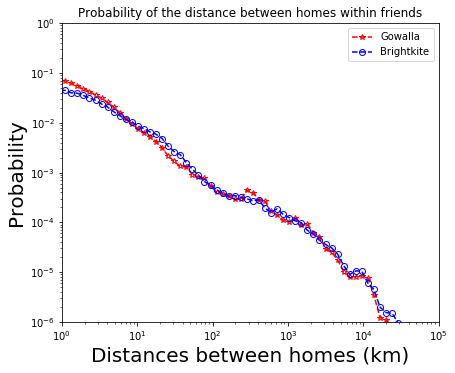

In [31]:
#MATCHING THE PROPORTION OF THE AXES WITH THE REFERENCE PLOT
plt.figure(figsize=(6.75,5.5))
#MATCHING THE AXES LIMITS WITH THE REFERENCE PLOT
plt.ylim((10**-6, 10**0))
plt.xlim((10**0, 10**5))
#PLOTTING THE PROBABILITY FOR EACH SOCIAL NETWORK
plt.loglog(Go_plot["probability"], "r*--",  Br_plot["probability"], "bo--", fillstyle = "none", label="Gowalla")
#ADDING LEGEND, TITLE AND AXIS LABELS
plt.legend(["Gowalla","Brightkite"])
plt.title("Probability of the distance between homes within friends")
plt.xlabel("Distances between homes (km)", fontsize=20)
plt.ylabel("Probability", fontsize=20)

The similarity between plots from my point of view is about 80-90%. (This was asked in the Google form)
<br>The main difference I see is in the valley in about 4000km which is not that deep.

# P4

In [59]:
Go_friends_ch = pd.DataFrame(Go_ed.groupby("id1")["id2"].count()).rename(columns={"id2":"n_friends"})

In [33]:
Go_nat = pd.read_csv("data/Go_nat.csv")

In [37]:
Go_ed = Go_ed.set_index("id1")
Go_ed["id1_nat"] = Go_nat.set_index("user")["country"]
Go_ed = Go_ed.reset_index().set_index("id2")
Go_ed["id2_nat"] = Go_nat.set_index("user")["country"]
Go_ed = Go_ed.reset_index()

In [40]:
Go_ed.dropna()

,id2,id1,distance,distance_approx,id1_nat,id2_nat
0,1,0,6130.083742,6621.078459,United States,United States
1,2,0,2526.025773,2625.334665,United States,United States
2,4,0,2501.168732,2625.334665,United States,Finland
3,5,0,4.095952,4.045538,United States,United States
4,7,0,0.690360,0.636045,United States,United States
...,...,...,...,...,...,...
663799,1903,58226,3334.921016,3158.882597,Lebanon,United States
663800,5566,58226,3927.888384,3800.863713,Lebanon,United States
663801,1903,58227,5.193126,4.867714,Lebanon,United States
663802,1930,58227,1303.327608,1252.533713,Lebanon,United States


In [60]:
Go_friends_ch["n_friends_same_country"] = Go_ed[Go_ed.id1_nat == Go_ed.id2_nat].groupby("id1")["id2"].count()

In [61]:
Go_friends_ch

,n_friends,n_friends_same_country
id1,,
0,442,442
1,558,558
2,944,944
5,477,477
7,27,27
...,...,...
58164,1,1
58170,2,2
58172,1,1


In [62]:
Go_friends_ch["ratio_friends_same_country"] = Go_friends_ch["n_friends_same_country"]/Go_friends_ch["n_friends"]

In [63]:
Go_friends_ch

,n_friends,n_friends_same_country,ratio_friends_same_country
id1,,,
0,442,442,1.0
1,558,558,1.0
2,944,944,1.0
5,477,477,1.0
7,27,27,1.0
...,...,...,...
58164,1,1,1.0
58170,2,2,1.0
58172,1,1,1.0


In [86]:
threshold = 50

In [87]:
Go_friends_ch["n_friends_near"] = Go_ed[Go_ed.distance < threshold].groupby("id1")["id2"].count()

In [88]:
Go_friends_ch = Go_friends_ch.fillna(0)

In [89]:
Go_friends_ch["ratio_friends_near"] = Go_friends_ch["n_friends_near"]/Go_friends_ch["n_friends"]

In [90]:
Go_friends_ch

,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
id1,,,,,
0,442,442,1.0,109.0,0.246606
1,558,558,1.0,0.0,0.000000
2,944,944,1.0,47.0,0.049788
5,477,477,1.0,190.0,0.398323
7,27,27,1.0,16.0,0.592593
...,...,...,...,...,...
58164,1,1,1.0,0.0,0.000000
58170,2,2,1.0,0.0,0.000000
58172,1,1,1.0,0.0,0.000000
